In [1]:
"""
This code calculates the Raman resonance response using the Kramers-Heisenberg Equation from a Wannier representation
of the band structure. It is written specifically for the Kagome system Co3Sn2S2, but can be adapted for other
materials as well. It reads in data from the wannier90_hr.dat output file from Wannier90. In this case, the
wannier orbitals roughly represent atomic Co orbitals dxy, dx2-y2 and dz2.
"""

import numpy as np
import matplotlib.pyplot as plt
import pickle
plt.rcParams['figure.dpi'] = 200
from utils import *

In [4]:
## Lattice parameters for magnetic, U=0
a1 = np.array([-2.6904714,    -1.5533444,     4.3841542])
a2 = np.array([2.6904716,    -1.5533444,     4.3841541])
a3 = np.array([-0.0000002,     3.1066888,     4.3841542])
V = np.dot(np.cross(a1, a2), a3)
b1 = 2*np.pi / V * (np.cross(a2, a3))
b2 = 2*np.pi / V * (np.cross(a3, a1))
b3 = 2*np.pi / V * (np.cross(a1, a2))
Co1 = np.array([-0.0000001,     1.5533444,     2.1920771])
Co2 = np.array([-1.3452357,    -0.7766722,     2.1920771])
Co3 = np.array([1.3452358,    -0.7766722,     2.1920770])

efermi =  8.3020246241    # eV --  may be lower. Different efermi from band vs wannier/scf calculations...
efermi = 8.312626817360066  # eV from density of states of Wanner

In [5]:
"""
Read hopping matrix element from the wannier90 output file:wannier90_hr.dat
wan_num: number of wannier functions
wsc_num: number of wigner-sitez cells
wsc_count: variables related to degeneracy
"""
def read_hamiltonian(path):
    with open(path,"r") as f:
        lines=f.readlines()

    wan_num=int(lines[1]); wsc_num=int(lines[2])
    ski_row_num=int(np.ceil(wsc_num/15.0))      # skip row numbers
    wsc_count=[]
    for i in range(ski_row_num):
        wsc_count.extend(list(map(int,lines[i+3].split())))

    wsc_tot=np.zeros((wan_num**2*wsc_num,3))
    tem_tot=np.zeros((wan_num**2*wsc_num,2))
    for i in range(wan_num**2*wsc_num):
        wsc_tot[i,:]=list(map(int,lines[3+ski_row_num+i].split()[:3]))
        tem_tot[i,:]=list(map(float,lines[3+ski_row_num+i].split()[5:]))

    wsc_idx=wsc_tot[0:-1:wan_num**2,:]   # the translational vector between wigner-sitez cells
    hop_mat=np.reshape(tem_tot[:,0]+1j*tem_tot[:,1],[wan_num,wan_num,wsc_num],order='F')

    return hop_mat,wsc_idx,wsc_count,wan_num

In [6]:
hop_mat, R, wsc_count, wan_num = read_hamiltonian('wannier90_hr.dat')
# print(R)

In [7]:
""" 
Build a Hamiltonian at any arbitrary k-point in the BZ, using the hr.dat data
"""
def build_matrix_np(R, hop_mat, k):
    ham = np.zeros((len(hop_mat[:, 0, 0]), len(hop_mat[:, 0, 0])), dtype = complex)  # 18x18 matrix
    for i in range(len(hop_mat[:, 0, 0])):
        for j in range(len(hop_mat[0, :, 0])):
            for r in range(len(R)):
                rad = R[r]
                ham[i, j] += hop_mat[i, j, r] * np.exp(2 * np.pi * 1j * np.dot(k, rad))
    return ham

In [8]:
# read in kpoints
with open("wannier90_band.kpt") as f:
    lines = f.readlines()
    lines = lines[1:]

kpath = []
for l in lines:
    vals = l.strip().split()[0:3]
    vals = [float(v) for v in vals]
    # kpath.append(np.dot(vals, [b1, b2, b3]))
    kpath.append(vals)
kpath = np.array(kpath)

In [23]:
# get band structures along kpoints in variable kpath
def get_bands(R, hop_mat):
    # kpath = make_kpoints()
    eigs = []
    for k in kpath:
        ham_k = build_matrix_np(R, hop_mat, k)
        bands = np.abs(np.linalg.eigvals(ham_k))
        eigs.append(bands.copy())
    return np.array(eigs)

bands = get_bands(R, hop_mat)

In [14]:
def plot_bands(bands):
    fig, ax = plt.subplots()
    x = np.arange(bands.shape[0])
    # print(x)
    for i in range(len(bands[0, :])):
        ax.scatter(x, bands[:, i]-efermi, s=.5, marker=".", c="b")
    ax.axvline(50, c="k", lw=1)
    ax.axvline(94, c="k", lw=1)
    ax.axvline(137, c="k", lw=1)
    plt.xlim((0, 200))
    plt.ylim(-0.5, 4)
    plt.xticks([0, 50, 93, 137, 198], ["W", "T", "U", "L", "G"])
    #plt.title("from bottom to top: xy, yz, zx, x2-y2, z2")
#     ax.axvline(200, c="k", lw=1)
#     ax.axvline(400, c="k", lw=1)
#     plt.xlim((0, 600))
#     plt.xticks([0, 200, 400, 600], ["G", "K", "M", "G"])
    #plt.savefig('tight_binding_kagome_d_spd_100.png', bbox_inches='tight')
# plot_bands(bands)

Text(0, 0.5, 'E - Efermi')

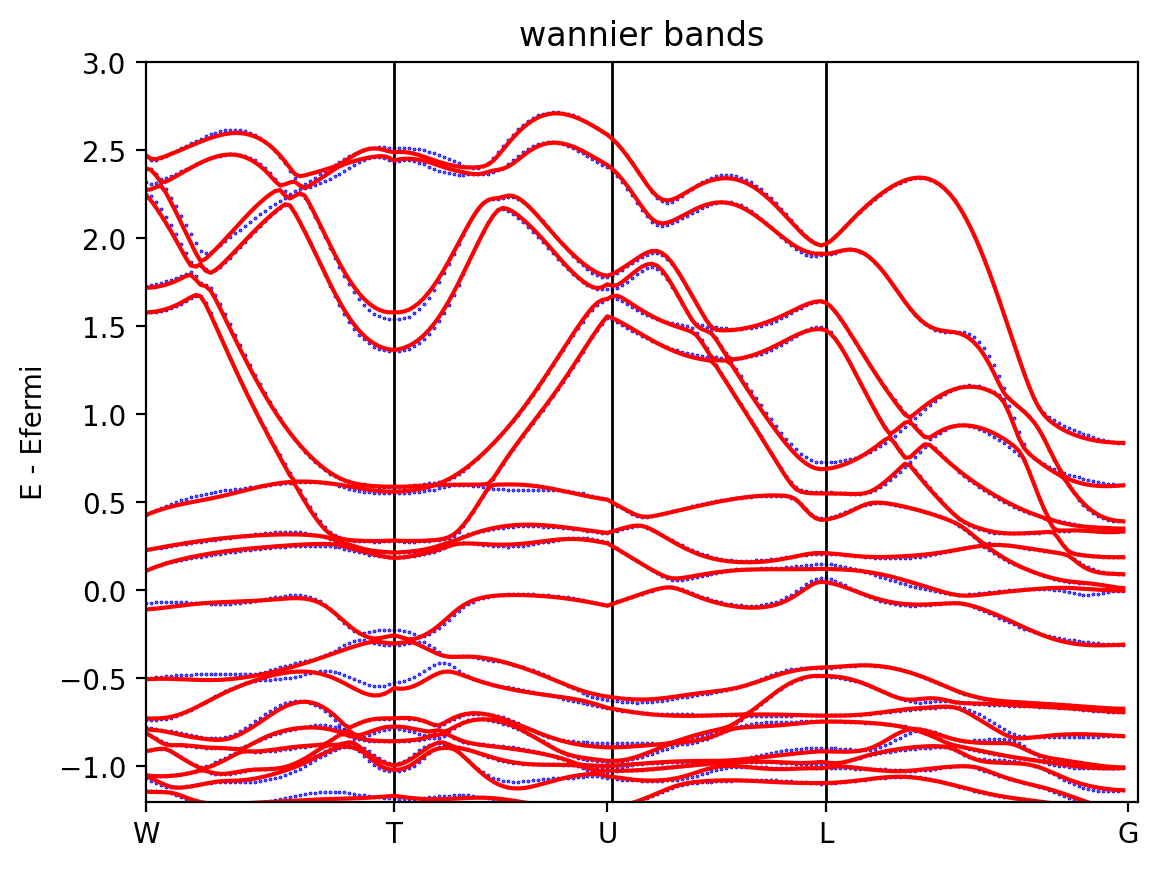

In [15]:
# Optional step: compare the bands calcualted from hr.dat to those calculated directly by Wannier90. They usually differ very slightly
def plot_wannier_directly(filename):
    data = np.loadtxt(filename, unpack = True)
    num_wann = wan_num
    segment_length = data.size // (2*num_wann)
    wann_bands = []
    #data[1] -= efermi
    wann_k = data[0][0:198]
#     print(len(wann_k))
    x = np.arange(len(wann_k))
#     print(x)
    for i in range(num_wann):
        wann_bands.append(data[1][198*i:198*(i+1)])
    for i in range(num_wann):
        plt.plot(x, wann_bands[i] - efermi, 'r')


plot_bands(bands)
plot_wannier_directly('wannier90_band.dat')
plt.ylim(-1.2, 3)
plt.title("wannier bands")
plt.ylabel("E - Efermi")

In [9]:
"""
change of basis for eigenvectors. Original basis is:
[Co1 dxy up, Co1 dxy dn, 1-dx2-y2-up, 1-dx2y2-dn, 1-dz2-up 1-dz2-dn, Co2-dxy-up, etc.]
new basis is [Co1 ml=-2 up, Co1 ml=-2 down, Co1 ml=0 up, Co1 ml=0 down, Co1 ml=2 up, Co1 ml=2 down, Co2 ml=-2 up, etc]
"""
def change_of_basis_matrix():
    trans_matrix = np.zeros((18, 18), dtype=complex)
    one_atom_matrix = np.zeros((6, 6), dtype=complex)
    one_atom_matrix[0, 0:3] = np.array([-1j / np.sqrt(2), 0,  1/np.sqrt(2)])    # Y_2,-2 up
    one_atom_matrix[1, 1:4] = np.array([-1j / np.sqrt(2), 0,  1/np.sqrt(2)])    # Y_2,-2 down
    one_atom_matrix[2, 4] = 1                                                   # Y_2,0 up
    one_atom_matrix[3, 5] = 1                                                   # Y_2,0 down
    one_atom_matrix[4, 0:3] = np.array([1j / np.sqrt(2), 0, 1/np.sqrt(2)])      # Y_2,2 up
    one_atom_matrix[5, 1:4] = np.array([1j / np.sqrt(2), 0, 1/np.sqrt(2)])      # Y_2,2 down
    for i in range(3):
        trans_matrix[i*6:(i+1)*6, i*6:(i+1)*6] = one_atom_matrix
    return trans_matrix

M = change_of_basis_matrix()
new_basis_mls = [-2, -2, 0, 0, 2, 2, -2, -2, 0, 0, 2, 2, -2, -2, 0, 0, 2, 2]
new_basis_mss = [1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1] # 1 = up, -1 = down

In [10]:
"""
gives c^1(1, pml, 2, dml)
"""
def gaunt_coefficient(pml, dml):
    # sign = (-1) ** (dml - pml)
    if (dml, pml) == (2, 1) or (dml, pml) == (-2, -1):
        return -np.sqrt(6/15)
    elif (dml, pml) == (1, 1) or (dml, pml) == (-1, -1):
        return np.sqrt(3/15)
    elif dml == 0 and np.abs(pml) == 1:
        return -np.sqrt(1/15)
    elif np.abs(dml) == 1 and pml == 0:
        return -np.sqrt(3/15)
    elif dml == 0 and pml == 0:
        return 2 /np.sqrt(15)
    else:
        return 0


In [11]:
"""
Returns a (6,) vector corresponding to the ml values of the intermediate basis, depending on the k vector, input in reciprocal lattice vectors (converted to spherical coords).
"""
def get_Y_k(k):
    p_mls = np.array([-1, -1, 0, 0, 1, 1])
    result = np.zeros_like(p_mls, dtype=complex)
    kx, ky, kz = np.dot(k, [b1, b2, b3])
    # return all zeros for undefined behaviour    
    if (np.abs(kx) < 0.0001) and (np.abs(ky) < 0.0001):
        if np.abs(kz) < 0.0001:
            return result
        else:
            result[p_mls == 0] = np.sqrt(3/(4*np.pi))
            return result
    
    theta = np.arccos(kz / np.linalg.norm([kx, ky, kz]))
    if ky == 0:
        sgn = 1
    else:
        sgn = np.sign(ky)
    
    phi = sgn * np.arccos(kx / np.linalg.norm([kx, ky]))

    mask1 = np.abs(p_mls) == 1
    result[mask1] = -p_mls[mask1] * np.sqrt(3 /  (8 * np.pi)) * np.sin(theta) * np.exp(p_mls[mask1] * phi * 1j)

    mask2 = p_mls == 0
    result[mask2] = np.sqrt(3 / (4 * np.pi)) * np.cos(theta)
    
    return result


In [12]:
"""
e_light is the photon polarization [ex, ey, ez] (doesn't need to be normalized)
    R = np.array([1, -1j, 0]) / np.sqrt(2)
    L = np.array([1, 1j, 0]) / np.sqrt(2)
    xp = np.array([1, 1, 0])/ np.sqrt(2)
    yp = np.array([-1, 1, 0])/ np.sqrt(2)

    v2 change: gives equivalent matrix, but shape is instead [num_p, num_d] = 6x18
"""
def build_dipole_table(e_light):
    e_light /= np.linalg.norm(e_light)
    n = {-1: (e_light[0] + 1j * e_light[1])/np.sqrt(2),
         0: e_light[2],
         1: (-e_light[0] + 1j * e_light[1])/np.sqrt(2)
         }
    new_basis_mls = [-2, -2, 0, 0, 2, 2, -2, -2, 0, 0, 2, 2, -2, -2, 0, 0, 2, 2]
    new_basis_mss = [1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1] # 1 = up, -1 = down
    num_d = len(new_basis_mls)

    p_mls = [-1, -1, 0, 0, 1, 1]
    p_mss = [1, -1, 1, -1, 1, -1]
    num_p = len(p_mls)
    table = np.zeros((num_p, num_d), dtype=complex)
    for i in range(num_d):
        dml = new_basis_mls[i]
        dms = new_basis_mss[i]
        for j in range(num_p):
            pml = p_mls[j]
            pms = p_mss[j]
            if dms != pms: continue     # no spin flips
            if np.abs(dml-pml) > 1: continue
            table[j, i] = gaunt_coefficient(pml, dml) * n[pml - dml]
    return table


    

In [13]:
""" 
note: dip_table_in should have dimensions (6, 18) and dip_table_out (18, 6)
This function calculates the resonance response at a single k point
params:
    k: k point in BZ in recip. lattice units (3x1 np.array of floats)
    trans_mat: matrix to transform from one basis (e.g. atomic orbitals like dxy, pz) to (ml, ms) basis (output of change_of_basis_matrix())
    dip_table_in: table with values for the dipole operator, D_in, between |i> and |nu>, corresponding to incident light polarization 
    dip_table_out: table with values for the dipole operator, D_out^\dagger between |nu> and |f>, corresponding to incident light polarization 
    k_weight: weight of this k-point in the overall spectrum. 
    hop_mat, R: data from hr.dat file
returns:
    result: a dict mapping final energies to dicts.
        the nested dicts map the initial state energy to sum(<f| D_out^\dagger | nu> <nu | D_in | i > )
"""
def new_get_spectra_k(k, trans_mat, dip_table_in, dip_table_out, k_weight=1.0, hop_mat=hop_mat, R=R):
    vals, vecs = np.linalg.eigh(build_matrix_np(R, hop_mat, k))
    VBs = np.argwhere(np.all([vals - efermi < 0, vals - efermi > -1.0], axis=0)).flatten()  # indices for E between -1 and 0
    CBs = np.argwhere(np.all([vals - efermi > 0, vals - efermi < 1], axis=0)).flatten()  # indices for E between 0 and 1
    Y_k = get_Y_k(k)

    result = {} # final energies -> {intial state energy -> sum(<f| D^\dagger | nu> <nu | D | i > )}

    for f in CBs:
        vec = np.matmul(trans_mat, vecs[:, f])
        f_dict = {}
        f_D_dagger = np.matmul(np.conj(vec), dip_table_out) * np.conj(Y_k)
        for i in VBs:
            vec2 = np.matmul(trans_mat, vecs[:, i])
            D_i = np.matmul(dip_table_in, vec2) * Y_k
            f_dict.update({vals[i]: np.dot(f_D_dagger, D_i) * np.sqrt(k_weight)})
        result.update({vals[f]: f_dict})
    return result


In [14]:
""" 
This function calculates the Raman resonance at all the k-points listed in klist
params:
    klist: list or numpy array of kpoints (Nx3 array)
    e_in, e_out: incident and final light polarizations
    k_weights: weights of kpoint. If k_weights==None, equal weighting is assumed
    hop_mat, R: data from hr.dat file
returns:
    result: a dict mapping final energies to dicts.
        the nested dicts map the initial state energy to sum(<f| D_out^\dagger | nu> <nu | D_in | i > )
        should be plotted using a Gaussian or Lorentzian  
"""
def new_get_full_spectra(klist, e_in, e_out, k_weights=None, hop_mat=hop_mat, R=R):
    dip_table_in = build_dipole_table(e_in)     # 6x18
    dip_table_out = np.conj(build_dipole_table(e_out)).T    # 18x6
    # omegas = np.linspace(0, 1.0, 300)   # in eVs
    # spec = np.zeros_like(omegas)
    trans_mat = change_of_basis_matrix()
    result = {}
    if not np.any(k_weights):
        k_weights = np.ones(len(klist)) / len(klist)   # asssumes equal weighting


    for ik, k in enumerate(klist):
        spec_k = new_get_spectra_k(k, trans_mat, dip_table_in, dip_table_out, k_weight=k_weights[ik], hop_mat=hop_mat, R=R) #TODO: figure out k_weights
        result.update(spec_k)
        # for i, E in enumerate(Ediffs):
        #     lorentzian = (gamma/np.pi) / (gamma**2 + (omegas - E)**2)
        #     spec += lorentzian * intensities
    return result
    

In [15]:
""" 
These functions are similar to get_new_spectra_k() and new_get_full_spectra(), except the calculate the
A1g, A2g, Eg1 and Eg2 responses using their "pure" definition, rather than calculating the spectra for any
arbitrary e_in and e_out. This is less general, but is much more efficient for calculating the pure Raman symmetries.
May need to be modified for non-Kagome systems. 
"""
def new_get_spectra_k_pure(k, trans_mat, dip_x, dip_y, k_weight=1.0, hop_mat=hop_mat, R=R):
    vals, vecs = np.linalg.eigh(build_matrix_np(R, hop_mat, k))
    VBs = np.argwhere(np.all([vals - efermi < 0, vals - efermi > -1.0], axis=0)).flatten()  # indices for E between -1 and 0
    CBs = np.argwhere(np.all([vals - efermi > 0, vals - efermi < 1], axis=0)).flatten()  # indices for E between 0 and 1
    Y_k = get_Y_k(k)

    result = {"A1g": {}, "A2g": {}, "Eg1": {}, "Eg2": {}} # each dict: final energies -> {intial state energy -> sum(<f| D^\dagger | nu> <nu | D | i > )}

    for f in CBs:
        vec = np.matmul(trans_mat, vecs[:, f])
        f_dict = {"A1g": {}, "A2g": {}, "Eg1": {}, "Eg2": {}}
        f_Dx_dagger = np.matmul(np.conj(vec), np.conj(dip_x).T) * np.conj(Y_k)
        f_Dy_dagger = np.matmul(np.conj(vec), np.conj(dip_y).T) * np.conj(Y_k)
        for i in VBs:
            vec2 = np.matmul(trans_mat, vecs[:, i])
            Dx_i = np.matmul(dip_x, vec2) * Y_k
            Dy_i = np.matmul(dip_y, vec2) * Y_k
            xx = np.dot(f_Dx_dagger, Dx_i)
            yy = np.dot(f_Dy_dagger, Dy_i)
            xy = np.dot(f_Dx_dagger, Dy_i)
            yx = np.dot(f_Dy_dagger, Dx_i)

            f_dict["A1g"].update({vals[i]: (xx + yy) * np.sqrt(k_weight)})
            f_dict["A2g"].update({vals[i]: (yx - xy) * np.sqrt(k_weight)})
            f_dict["Eg1"].update({vals[i]: (xx - yy) * np.sqrt(k_weight)})
            f_dict["Eg2"].update({vals[i]: (yx + xy) * np.sqrt(k_weight)})


        for sym in result.keys():
            result[sym].update({vals[f]: f_dict[sym]})
    return result

def new_get_full_spectra_pure(klist, k_weights=None, hop_mat=hop_mat, R=R):
    dip_x = build_dipole_table([1, 0, 0])     # 6x18
    dip_y = build_dipole_table([0, 1, 0])


    # omegas = np.linspace(0, 1.0, 300)   # in eVs
    # spec = np.zeros_like(omegas)
    trans_mat = change_of_basis_matrix()
    result = {"A1g": {}, "A2g": {}, "Eg1": {}, "Eg2": {}}
    if not np.any(k_weights):
        k_weights = np.ones(len(klist)) / len(klist)   # asssumes equal weighting


    for ik, k in enumerate(klist):
        spec_k = new_get_spectra_k_pure(k, trans_mat, dip_x, dip_y, k_weight=k_weights[ik], hop_mat=hop_mat, R=R) #TODO: figure out k_weights
        for sym in result.keys():
            result[sym].update(spec_k[sym])
        # for i, E in enumerate(Ediffs):
        #     lorentzian = (gamma/np.pi) / (gamma**2 + (omegas - E)**2)
        #     spec += lorentzian * intensities
    return result

In [16]:
""" 
Plots the outputs of new_get_full_spectra() or new_get_full_spectra_pure(), using a Lorentzian smearing.
params:
    result: output of new_get_full_spectra() or new_get_full_spectra_pure()
    omegas: x-axis in units of energy
    gamma: Lorentzian smearing parameter
    E_nu: energy of fictitious intermediate p-state
    Gamma_nu: value of \Gamma_nu in Kramers-Heisenberg
    show_plot: toggles whether plot is shown
returns:
    spec: spectra in arbitrary units. Same length as omegas
"""
def plot_spectra(result, omegas, gamma, w_i, E_nu, Gamma_nu, show_plot=False):
    spec = np.zeros_like(omegas)
    
    for E_f in result.keys():
        for E_i in result[E_f].keys():
            lorentzian = (gamma/np.pi) / (gamma**2 + (omegas - (E_f - E_i))**2)
            intensity = result[E_f][E_i] / (w_i - (E_nu - E_i) + 1j * Gamma_nu)
            # print(np.imag(intensity * np.conj(intensity)))
            spec += lorentzian * np.abs(intensity)**2
    if show_plot:
        plt.plot(omegas, spec)
    return spec
    
                                          
        

In [19]:
xx = new_get_full_spectra(kpath, [1, 0, 0], [1, 0, 0])
xpxp = new_get_full_spectra(kpath, [1, 1, 0], [1, 1, 0])
RR = new_get_full_spectra(kpath, [1, -1j, 0], [1, -1j, 0])
xy = new_get_full_spectra(kpath, [1, 0, 0], [0, 1, 0])
xpyp = new_get_full_spectra(kpath, [1, 1, 0], [-1, 1, 0])
RL = new_get_full_spectra(kpath, [1, -1j, 0], [1, 1j, 0])

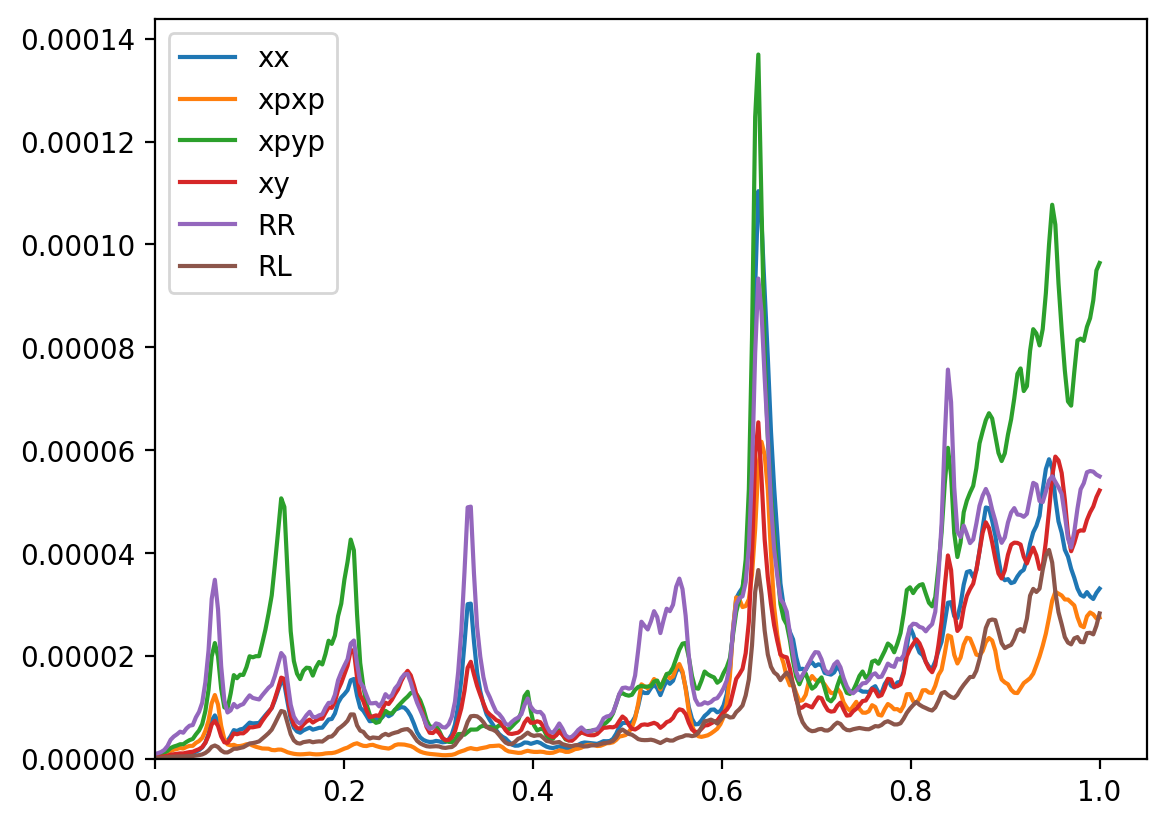

In [20]:
omegas = np.linspace(0, 1.0, 300)   # in eVs
names = "xx xpxp xpyp xy RR RL".split()
gamma = 0.005
w_i = 1240 / 575
results = [xx, xpxp, xpyp, xy, RR, RL]
E_nu = 4.0
specs = []

for i in range(len(results)):
    spec = plot_spectra(results[i], omegas, gamma, w_i, E_nu, Gamma_nu=0.005, show_plot=False)
    specs.append(spec)
    plt.plot(omegas, spec, label=names[i])

plt.xlim(left=0)
plt.ylim(bottom=0)
plt.legend()

In [17]:
""" 
for experimental derivation of pure symmetries
Order MUST be [xx, xpxp, xpyp, xy, RR, RL]
"""
def get_symmetries_expt(omegas, specs):
    [xx, xpxp, xpyp, xy, RR, RL] = specs
    A1g = (1/3) * (xx + xpxp + RR - (1/2) * (xy + xpyp + RL))
    A2g = (1/3) * (xy + xpyp + RR - (1/2) * (xx + xpxp + RL))
    Eg1 = (1/3) * (xx + xpyp + RL - (1/2) * (xy + xpxp + RR))
    Eg2 = (1/3) * (xy + xpxp + RL - (1/2) * (xx + xpyp + RR))
    raman_names = "A1g A2g Eg1 Eg2".split()

    for i, spec in enumerate([A1g, A2g, Eg1, Eg2]):
        plt.plot(omegas, spec, label = raman_names[i])
    plt.legend()
    return [A1g, A2g, Eg1, Eg2]
    

In [18]:
""" 
for plotting results from "new_get_full_spectra_pure()"
"""
def plot_symmetries_pure(omegas, result_pure, gamma, w_i, E_nu, Gamma_nu, show_plot=True):
    spec = {}
    for sym in result_pure.keys():
        spec[sym] = np.zeros_like(omegas)
        result = result_pure[sym]
        for E_f in result.keys():
            for E_i in result[E_f].keys():
                lorentzian = (gamma/np.pi) / (gamma**2 + (omegas - (E_f - E_i))**2)
                intensity = result[E_f][E_i] / (w_i - (E_nu - E_i) + 1j * Gamma_nu)
                # print(np.imag(intensity * np.conj(intensity)))
                spec[sym] += lorentzian * np.abs(intensity)**2
        if show_plot:
            plt.plot(omegas, spec[sym], label=sym)
    plt.legend()

In [19]:
""" 
read k-points and their weights from a VASP IBZKPT file. In general this is not a good solution as the Raman resonance
does not generally have the same symmetry as eigenvalues
"""
def read_IBZKPT(filename):
    klist = []
    weights = []
    with open(filename) as f:
        f.readline()
        num_k = int(f.readline().strip())
        f.readline()
        for i in range(num_k):
            l = f.readline().strip().split()
            klist.append([float(x) for x in l[0:3]])
            weights.append(float(l[3]) / num_k)

    return np.array(klist), np.array(weights) / np.sum(weights)

In [48]:
""" 
Enumerates k-points that span the entire BZ
"""
def make_k_block(nx, ny, nz):
    kpath = []
    for x in range(nx):
        for y in range(ny):
            for z in range(nz):
                kpath.append([x/nx, y/ny, z/nz])
    return np.array(kpath)


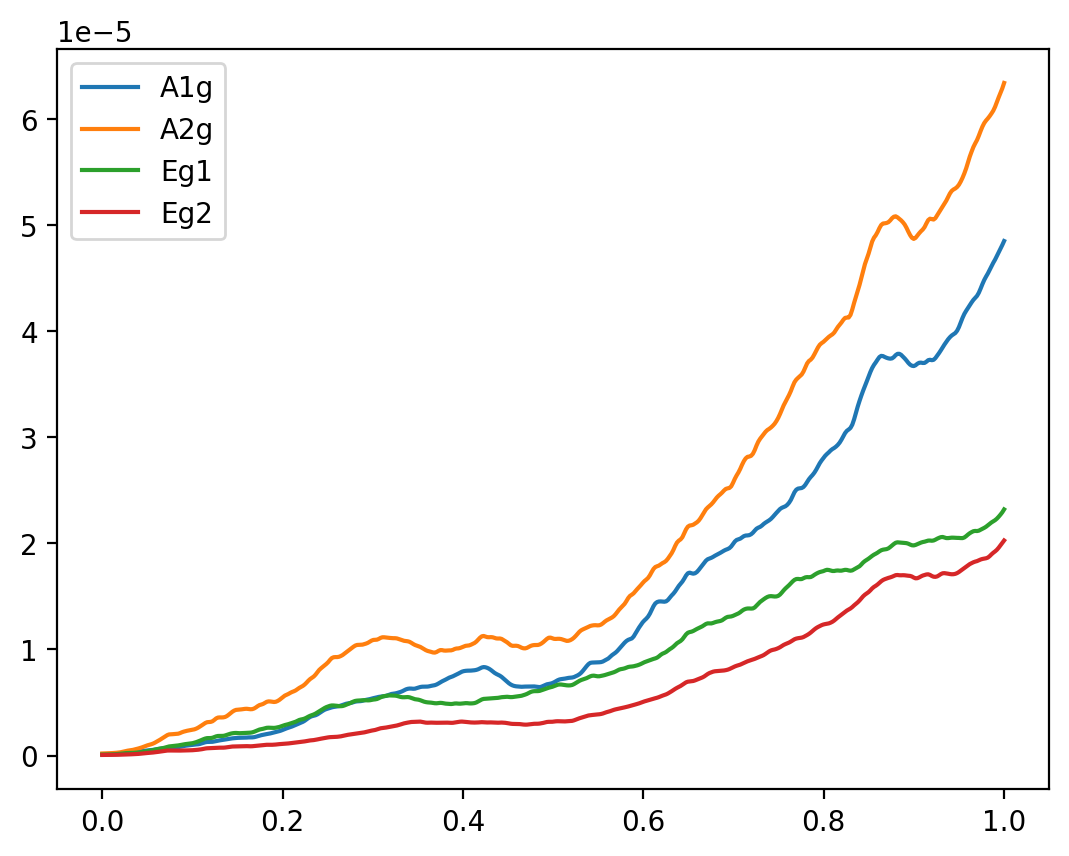

In [224]:
# Run the calculation on a dense k-grid (takes a long time)
kpath = make_k_block(39, 39, 39)
result_pure = new_get_full_spectra_pure(kpath)

plot_symmetries_pure(omegas, result_pure, gamma=0.005, w_i=1240/575, E_nu=4.0, Gamma_nu=0.005)
with open('specs_from393939block_pure_v2_newEf.pkl', 'wb') as f:
    pickle.dump(result_pure, f)

Text(0.5, 0, 'Raman Shift [eV]')

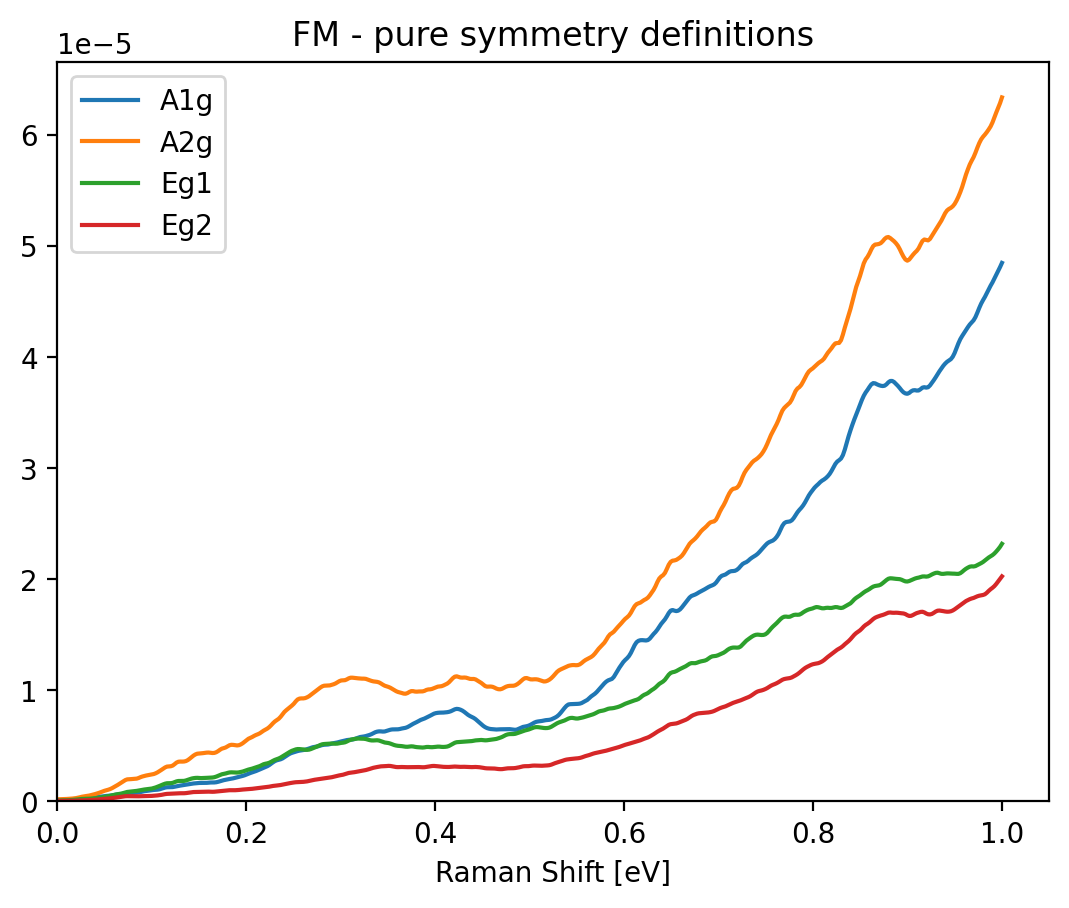

In [52]:
plot_symmetries_pure(omegas, result_pure, gamma=0.005, w_i=1240/575, E_nu=4.0, Gamma_nu=0.005)
plt.title("FM - pure symmetry definitions")
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.xlabel("Raman Shift [eV]")

In [227]:
kpath = make_k_block(39, 39, 39)
k_weights = None
xx = new_get_full_spectra(kpath, [1, 0, 0], [1, 0, 0])
xpxp = new_get_full_spectra(kpath, [1, 1, 0], [1, 1, 0])
RR = new_get_full_spectra(kpath, [1, -1j, 0], [1, -1j, 0])
xy = new_get_full_spectra(kpath, [1, 0, 0], [0, 1, 0])
xpyp = new_get_full_spectra(kpath, [1, 1, 0], [-1, 1, 0])
RL = new_get_full_spectra(kpath, [1, -1j, 0], [1, 1j, 0])

In [239]:
with open('specs_from393939block_expt_v2.pkl', 'wb') as f:
    pickle.dump({"xx": xx,
               "xpxp": xpxp,
               "xpyp": xpyp,
               "xy": xy,
               "RR": RR,
               "RL": RL
    }, f)

In [53]:
with open('specs_from393939block_expt_v2.pkl', 'rb') as f:
    SCF_dict = pickle.load(f)

Text(0.5, 0, 'Raman Shift [eV]')

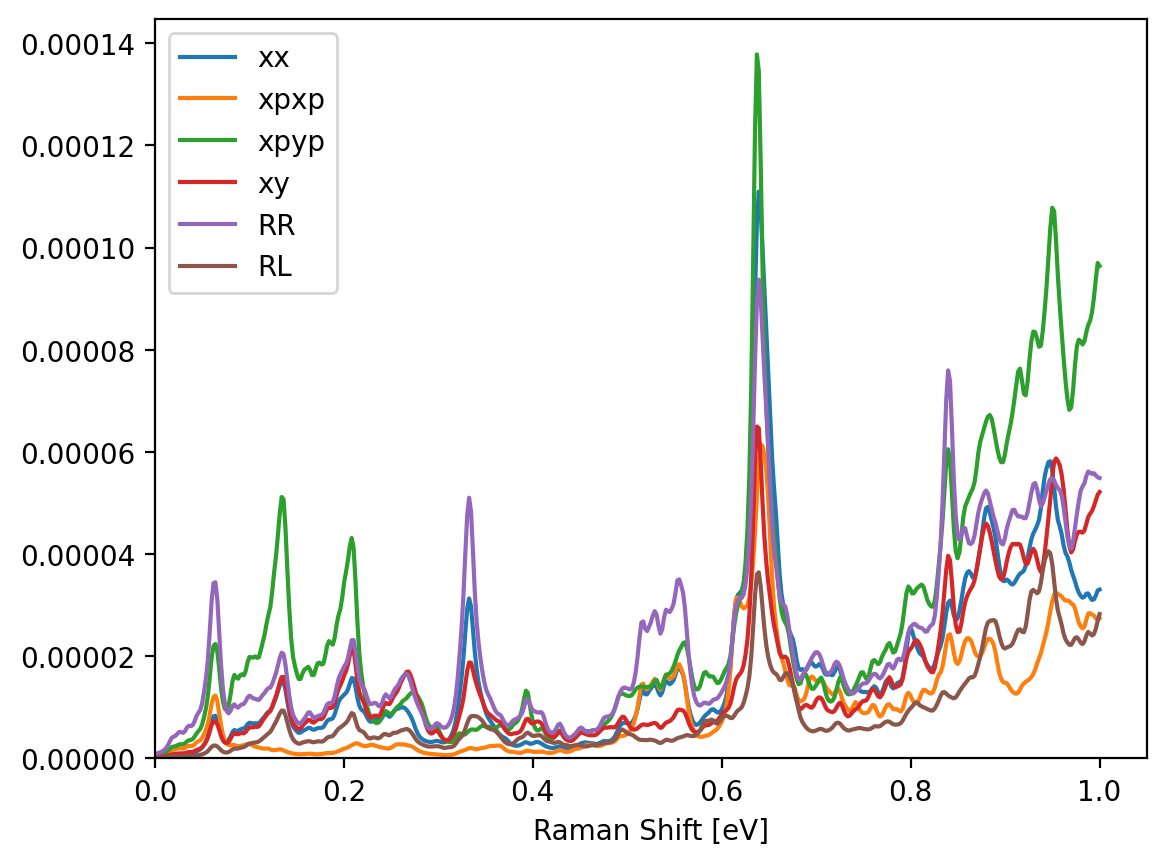

In [39]:
omegas = np.linspace(0, 1.0, 500)   # in eVs
names = "xx xpxp xpyp xy RR RL".split()
gamma = 0.005
w_i = 1240 / 575
results = [xx, xpxp, xpyp, xy, RR, RL]
E_nu = 4.0
specs = []

for i in range(len(results)):
    spec = plot_spectra(results[i], omegas, gamma, w_i, E_nu, Gamma_nu=0.005, show_plot=False)
    specs.append(spec)
    plt.plot(omegas, spec, label=names[i])

plt.xlim(left=0)
plt.ylim(bottom=0)
plt.legend()
plt.xlabel("Raman Shift [eV]")

Text(0.5, 0, 'Raman Shift [eV]')

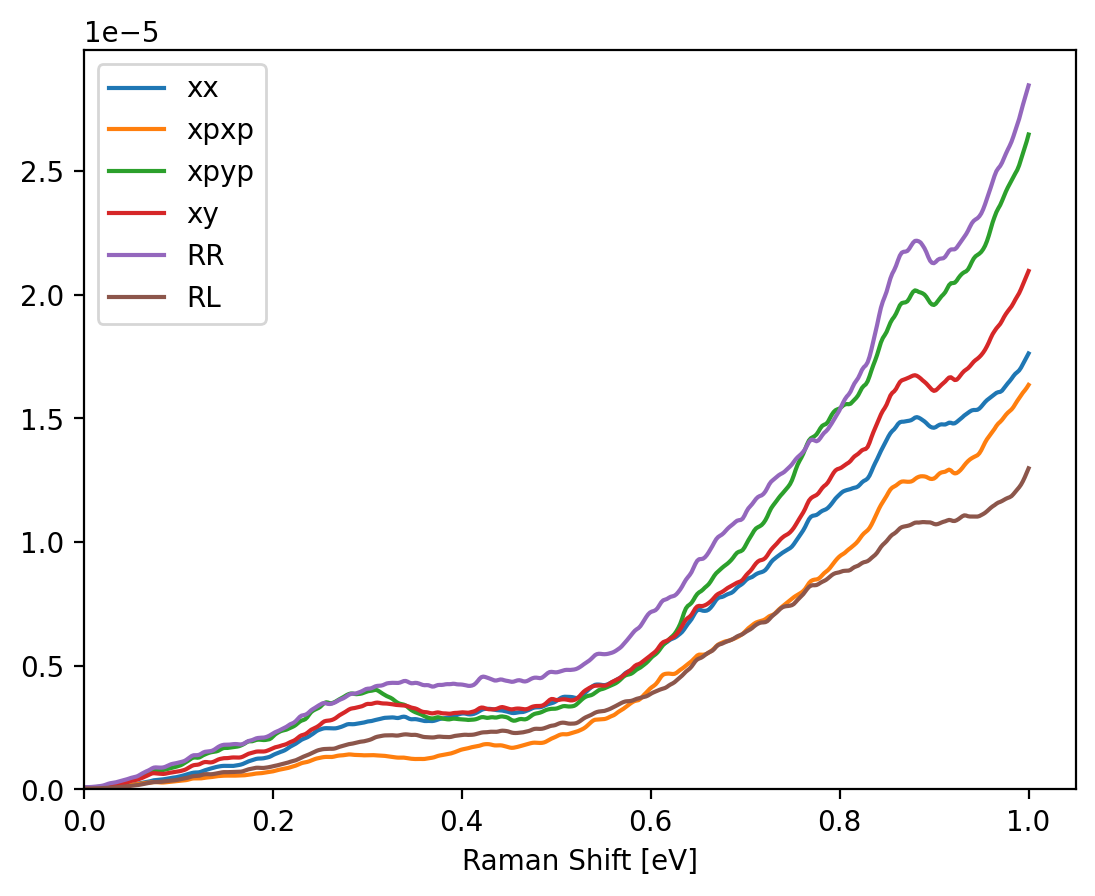

In [54]:
#for loaded dict
omegas = np.linspace(0, 1.0, 500)   # in eVs
names = "xx xpxp xpyp xy RR RL".split()
gamma = 0.005
w_i = 1240 / 575
# results = [xx, xpxp, xpyp, xy, RR, RL]
E_nu = 4.0
specs_FM = []

for i in range(len(names)):
    spec = plot_spectra(SCF_dict[names[i]], omegas, gamma, w_i, E_nu, Gamma_nu=0.005, show_plot=False)
    specs_FM.append(spec)
    plt.plot(omegas, spec, label=names[i])

plt.xlim(left=0)
plt.ylim(bottom=0)
plt.legend()
plt.xlabel("Raman Shift [eV]")

Text(0.5, 0, 'Raman Shift [eV]')

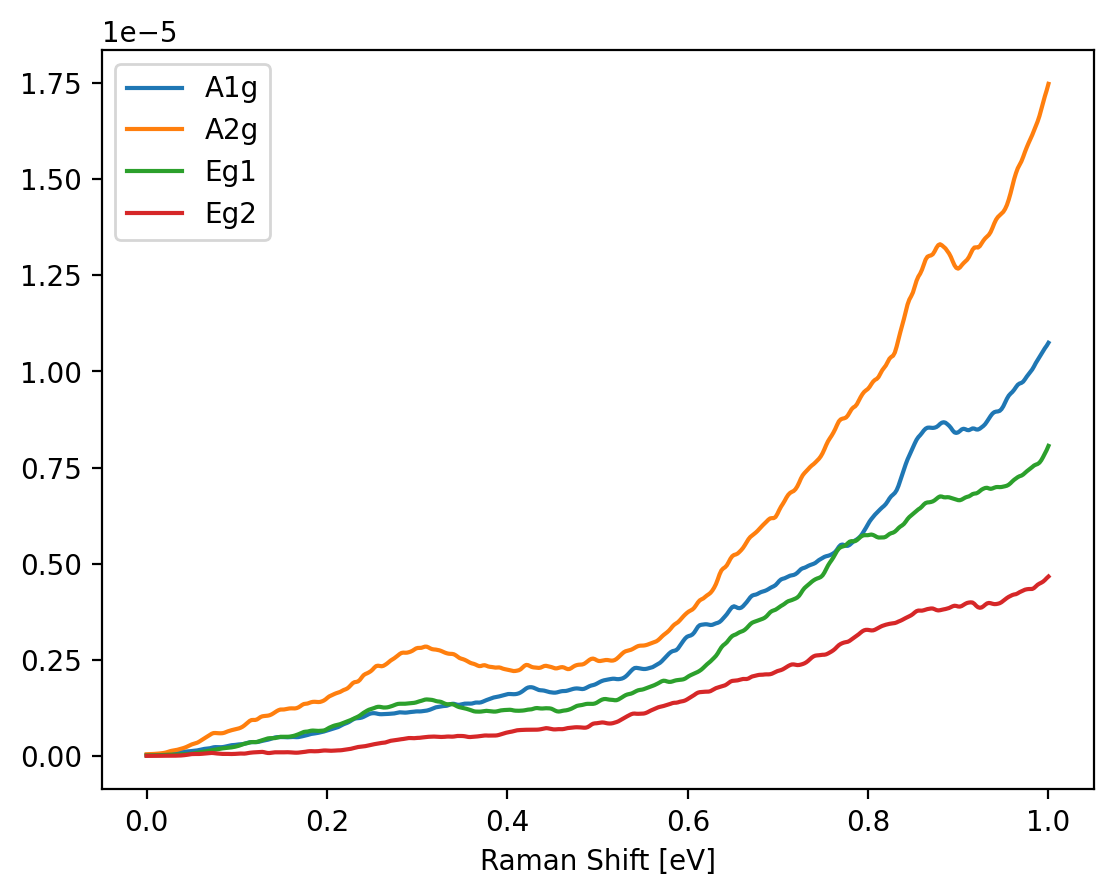

In [35]:
raman_specs = get_symmetries_expt(omegas, specs_FM)
plt.xlabel("Raman Shift [eV]")

In [2]:
""" 
creates a list of k-points near a central point in the BZ
"""
def k_cluster(center, spacing, num_points, b1, b2, b3):
    kpoints = []
    for i in range(num_points[0]):
        for j in range(num_points[1]):
            for k in range(num_points[2]):
                kpoint = [center[0] + (i - num_points[0]//2)*spacing[0],
                        center[1] + (j - num_points[1]//2)*spacing[1],
                        center[2] + (k - num_points[2]//2)*spacing[2]]
                kpoints.append(kpoint)
    kpoints = np.array(kpoints)
    v1 = b1 * spacing[0] * num_points[0]
    v2 = b2 * spacing[1] * num_points[1]
    v3 = b3 * spacing[2] * num_points[2]

    V_cluster = np.dot(np.cross(v1, v2), v3)
    V_BZ = np.dot(np.cross(b1, b2), b3)

    num_k = np.prod(num_points)
    
    weights = np.ones((num_k)) / num_k * V_cluster / V_BZ

    return kpoints, weights 
